In [1]:
import numpy as np
from numpy.linalg import pinv
import matplotlib.pyplot as plt

from sklearn import datasets 
from sklearn.model_selection import train_test_split

import pandas as pd
import seaborn as sns

In [2]:
# grad the dataset from sklearn datasets
in_data = datasets.load_breast_cancer()
# store features and data points (569 data points X 30 features)
df = pd.DataFrame(in_data.data, columns=in_data.feature_names)
# store data in array
data = df.values
# store binary diagnoses for 569 data points (0=malignant, 1=benign)
targets = in_data['target']

In [22]:
###################
# helper functions
###################

def init_weights(data, targets):
    X = data
    y = targets
    # add bias term x0=1 to the data
    X = np.column_stack((np.ones(X.shape[0]), X))
    # initialize weights using linear regression
    X_dag = pinv(X)
    w = np.matmul(X_dag, y)

    expected_shape = (X.shape[1],)

    # Check the shape of the result
    if w.shape != expected_shape:
        raise ValueError(f"Output has shape {result.shape}, but expected shape is {expected_shape}.")
    
    return X, w

def separate_test(data, targets, num_test_elems: int=69, random_state: int=None):
    if random_state is not None:
        np.random.seed(random_state)
        
    X = data
    num_remove = num_test_elems
    # store indices for removal from data and use as test set
    remove_indices = np.random.choice(np.arange(X.shape[0]), size=num_remove, replace=False)
    X_test = X[remove_indices, :]    # shape (69,20)
    y_test = targets[remove_indices]   # shape (69,)
    
    # remove the test set from the training data
    X = np.delete(X, remove_indices, axis=0)   # shape (500, 20)
    y = np.delete(targets, remove_indices, axis=0)   # shape (500,)
    
    return X, X_test, y, y_test

def create_train_val(X, y, N_arr, random_state: int=None):
    if random_state is not None:
        np.random.seed(random_state)
    # split the training data into 10 sample sets with training and validation sets
    X_train_set = []
    y_train_set = []
    for num in N_arr:
        if num < 500:
            X_train, _, y_train, _ = train_test_split(X, y, train_size=num, random_state=42)
        else: 
            X_train = X; y_train = y
            
        X_train_set.append(X_train); y_train_set.append(y_train);

    return X_train_set, y_train_set

def predict(X, w):
    return np.sign(np.dot(X,w))

def calculate_Ein(X, y, w):
    predictions = predict(X, w)
    return np.sum(predictions != y) / len(y)

###################
# pocket algorithm
###################
def pocket(X, y, w, max_iters: int = 1000, random_state: int=None):
    if random_state is not None:
        np.random.seed(random_state)
    '''
    Vectorized version of the pocket algorithm 
    based on the algorithm outlined in Learning from Data S3.1, pg 80.
    
    Args:
        X: set of input data points (N x d array)
        y: true value of output (N, array)
        w: initial weights (d, array)
        max_iters: maximum number of iterations before exiting

    Returns:
        pocket_w: pocket weights associated with the model
        min_Ein: the minimum error of the pocket weights
    '''
    N, d = X.shape  # N: number of points, d: number of features
    pocket_w = w.copy()  # Set pocket weight vector to initial weights
    Ein_min = calculate_Ein(X, y, w)  # Initialize pocket error as current error

    for t in range(max_iters):
        # Vectorized prediction
        predictions = np.sign(X @ w)
        # Find misclassified points
        misclassified = np.where(predictions != y)[0]

        # Stop if no misclassified points (PLA converged)
        if misclassified.size == 0:
            print(f'PLA converged after {t} iterations.')
            break

        # Randomly pick a misclassified point and update weights
        random_idx = np.random.choice(misclassified)
        w += y[random_idx] * X[random_idx]  # PLA update

        # Evaluate Ein for the new weight vector w(t+1)
        current_Ein = calculate_Ein(X, y, w)

        # If w(t+1) is better than pocket_w, update pocket_w
        if current_Ein < Ein_min:
            pocket_w = w.copy()  # Update pocket weights
            Ein_min = current_Ein  # Update minimum Ein

    # Return the best pocket weights
    return pocket_w, Ein_min

################
# evaluation 
################

def calculate_Ein_vals(X, y, w, N: int=10):
    best_weights = []
    E_ins = []
    for i in range(N):
        best_weight, Ein = pocket(X[i], y[i], w)
        best_weights.append(best_weight)
        E_ins.append(Ein)

    return np.array(E_ins), np.array(best_weights)

def calculate_error(X_set, y_set, best_weights):
    """
    Calculate errors and number of misclassified points for each subset.
    
    Args:
        X_val: List or array-like of shape (10, N, n) containing validation data subsets.
        y_val: List or array-like of shape (10, N) containing true labels for each subset.
        best_weights: List of weight arrays, one for each subset.
        
    Returns:
        num_misclassified: NumPy array of number of misclassified points for each subset.
        val_errors: NumPy array of validation error rates for each subset.
    """
    num_misclassified = []
    errors = []
    
    # Iterate over each subset of validation data
    for i in range(len(X_set)):
        predictions = predict(X_set[i], best_weights[i])
        missed = np.sum(predictions != y_set[i])  # Count how many predictions are incorrect
        error = missed / len(y_set[i])  # Calculate the error rate
        
        # Store the results for each subset
        num_misclassified.append(missed)
        errors.append(error)
    
    return np.array(num_misclassified), np.array(errors)

def calculate_Eouts(X_test, y_test, best_weights):
    num_misclassified = []
    test_errors = []
    for i in range(len(best_weights)):
        predictions = predict(X_test, best_weights[i])
        missed = np.sum(predictions != y_test)
        test_error = missed / len(y_test)

        num_misclassified.append(missed)
        test_errors.append(test_error)

    return np.array(missed), np.array(test_errors)


############################
# function to run the model
# and output results
############################

def run_model(data, targets, random_state: int=42):
    np.random.seed(random_state)
    
    ## array of data set sizes
    N = np.array([10,50,100,200,250,300,350,400,450,500])
    
    ####################
    #  prep data
    ####################
    # initialize the weights using linear regression
    X_bias, w = init_weights(data, targets)
    # separate out the test data
    X, X_test, y, y_test = separate_test(X_bias, targets)
    # create training and validation sets
    X_train_set, y_train_set = create_train_val(X, y, N)

    #########################
    # calculate Ein and Eout
    #########################
    Eins, best_weights = calculate_Ein_vals(X_train_set, y_train_set, w)
    num_misses, Eouts = calculate_Eouts(X_test, y_test, best_weights)
    print('N: Ein   Eout')
    for i, n in enumerate(N):
        print(f'{n}: {100*Eins[i]:.02f}%  {100*Eouts[i]:.02f}%')

# Run model on unaltered data

In [23]:
run_model(data, targets, random_state=42)

N: Ein   Eout
10: 40.00%  33.33%
50: 36.00%  33.33%
100: 29.00%  33.33%
200: 35.00%  33.33%
250: 36.00%  33.33%
300: 37.00%  33.33%
350: 36.86%  33.33%
400: 38.00%  33.33%
450: 37.78%  33.33%
500: 37.80%  33.33%


# First DT: adjust targets from [0,1] to [-1,1]

In [24]:
targets_adj = np.where(targets==0, -1, targets)
run_model(data, targets_adj, random_state=42)

PLA converged after 0 iterations.
N: Ein   Eout
10: 0.00%  2.90%
50: 2.00%  2.90%
100: 3.00%  2.90%
200: 4.00%  2.90%
250: 5.20%  2.90%
300: 7.67%  4.35%
350: 6.86%  4.35%
400: 7.25%  2.90%
450: 6.67%  2.90%
500: 7.40%  4.35%


# EDA

In [25]:
# inspect the data
df.describe(include="all") 

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


## First DT: normalization

In [33]:
# normalize the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.values)

# convert back to dataframe for easy inspection 
df_scaled = pd.DataFrame(scaled_data, columns=df.columns)
df_scaled.T

,0,1,2,3,4,5,6,7,8,9,...,559,560,561,562,563,564,565,566,567,568
mean radius,0.521037,0.643144,0.601496,0.210090,0.629893,0.258839,0.533343,0.318472,0.284869,0.259312,...,0.214350,0.334564,0.199678,0.389938,0.659709,0.690000,0.622320,0.455251,0.644564,0.036869
mean texture,0.022658,0.272574,0.390260,0.360839,0.156578,0.202570,0.347311,0.376057,0.409537,0.484613,...,0.480893,0.589787,0.664863,0.707136,0.520122,0.428813,0.626987,0.621238,0.663510,0.501522
mean perimeter,0.545989,0.615783,0.595743,0.233501,0.630986,0.267984,0.523875,0.320710,0.302052,0.277659,...,0.212356,0.328865,0.185751,0.411927,0.685578,0.678668,0.604036,0.445788,0.665538,0.028540
mean area,0.363733,0.501591,0.449417,0.102906,0.489290,0.141506,0.380276,0.184263,0.159618,0.140997,...,0.110286,0.193807,0.102863,0.243224,0.510498,0.566490,0.474019,0.303118,0.475716,0.015907
mean smoothness,0.593753,0.289880,0.514309,0.811321,0.430351,0.678613,0.379164,0.598267,0.674099,0.595558,...,0.360928,0.421233,0.197346,0.470976,0.517017,0.526948,0.407782,0.288165,0.588336,0.000000
mean compactness,0.792037,0.181768,0.431017,0.811361,0.347893,0.461996,0.274891,0.445126,0.533157,0.675480,...,0.253727,0.285933,0.049690,0.580701,0.626403,0.296055,0.257714,0.254340,0.790197,0.074351
mean concavity,0.703140,0.203608,0.462512,0.565604,0.463918,0.369728,0.264058,0.219447,0.435567,0.532568,...,0.260544,0.104545,0.000000,0.597470,0.743674,0.571462,0.337395,0.216753,0.823336,0.000000
mean concave points,0.731113,0.348757,0.635686,0.522863,0.518390,0.402038,0.367793,0.297465,0.464861,0.424602,...,0.204026,0.213917,0.000000,0.468638,0.732604,0.690358,0.486630,0.263519,0.755467,0.000000
mean symmetry,0.686364,0.379798,0.509596,0.776263,0.378283,0.518687,0.370707,0.573737,0.651515,0.489899,...,0.165657,0.240909,0.000000,0.539394,0.550000,0.336364,0.349495,0.267677,0.675253,0.266162
mean fractal dimension,0.605518,0.141323,0.211247,1.000000,0.186816,0.551179,0.157119,0.517060,0.504002,0.683867,...,0.331508,0.247473,0.106571,0.454086,0.396588,0.132056,0.113100,0.137321,0.425442,0.187026


In [34]:
# test model on normalized data
run_model(scaled_data, targets_adj)

PLA converged after 0 iterations.
PLA converged after 2 iterations.
PLA converged after 302 iterations.
PLA converged after 805 iterations.
PLA converged after 923 iterations.
N: Ein   Eout
10: 0.00%  2.90%
50: 0.00%  2.90%
100: 0.00%  5.80%
200: 0.00%  4.35%
250: 0.00%  2.90%
300: 0.67%  4.35%
350: 0.57%  4.35%
400: 0.50%  7.25%
450: 0.67%  4.35%
500: 0.80%  2.90%


## Second DT: remove highly correlated data

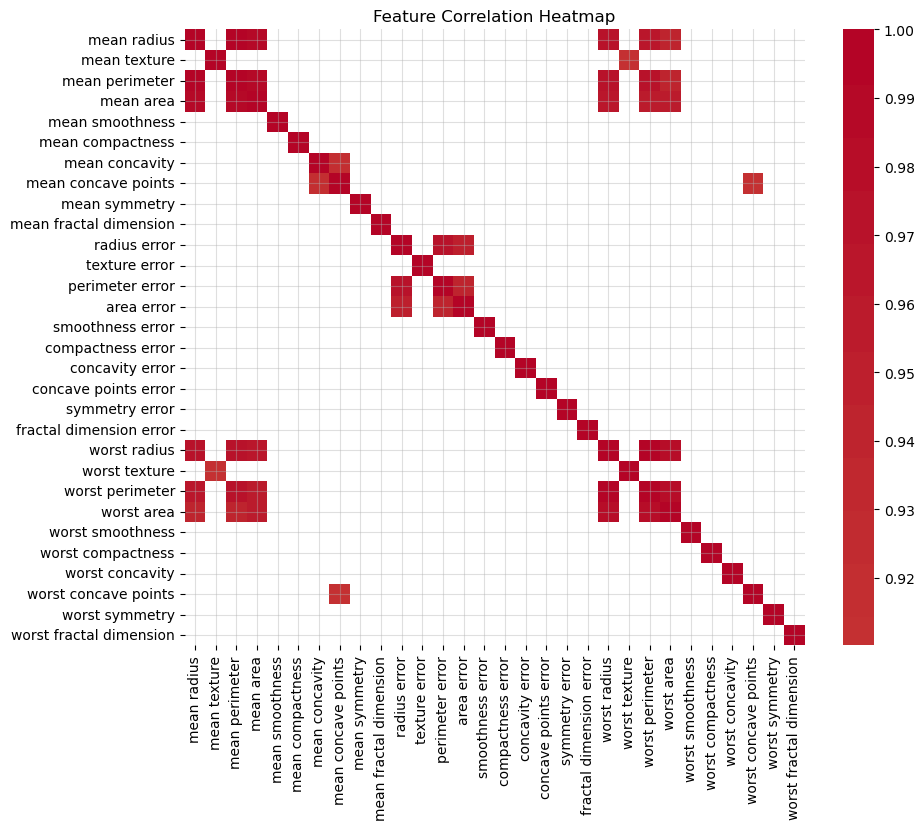

In [31]:
# make a heatmap of the features and look for heavy correlations (positive or negative)
correlation_matrix = df.corr()
# I only want to see strong correlations or anti-correltions
threshold = 0.9
correlation_matrix = correlation_matrix.where(np.abs(correlation_matrix) >= threshold)

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.grid(alpha=0.4)
plt.show()

Features to remove:
- mean permiter
- mean area
- worst radius
- worst perimeter
- worst area

In [36]:
features_to_remove = ['mean perimeter', 
                      'mean area', 
                      'worst radius', 
                      'worst perimeter',
                      'worst area']
# Get the indices of these features in the DataFrame
indices = df_scaled.columns.get_indexer(features_to_remove)
print("Indices of features to remove:", indices)

# Drop these features from the DataFrame
df_reduced = df_scaled.drop(columns=features_to_remove)
print("\nDataFrame after dropping specified features:")
df_reduced


Indices of features to remove: [ 2  3 20 22 23]

DataFrame after dropping specified features:


,mean radius,mean texture,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,...,concave points error,symmetry error,fractal dimension error,worst texture,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,0.521037,0.022658,0.593753,0.792037,0.703140,0.731113,0.686364,0.605518,0.356147,0.120469,...,0.300625,0.311645,0.183042,0.141525,0.601136,0.619292,0.568610,0.912027,0.598462,0.418864
1,0.643144,0.272574,0.289880,0.181768,0.203608,0.348757,0.379798,0.141323,0.156437,0.082589,...,0.253836,0.084539,0.091110,0.303571,0.347553,0.154563,0.192971,0.639175,0.233590,0.222878
2,0.601496,0.390260,0.514309,0.431017,0.462512,0.635686,0.509596,0.211247,0.229622,0.094303,...,0.389847,0.205690,0.127006,0.360075,0.483590,0.385375,0.359744,0.835052,0.403706,0.213433
3,0.210090,0.360839,0.811321,0.811361,0.565604,0.522863,0.776263,1.000000,0.139091,0.175875,...,0.353665,0.728148,0.287205,0.385928,0.915472,0.814012,0.548642,0.884880,1.000000,0.773711
4,0.629893,0.156578,0.430351,0.347893,0.463918,0.518390,0.378283,0.186816,0.233822,0.093065,...,0.357075,0.136179,0.145800,0.123934,0.437364,0.172415,0.319489,0.558419,0.157500,0.142595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,0.690000,0.428813,0.526948,0.296055,0.571462,0.690358,0.336364,0.132056,0.385479,0.197976,...,0.464861,0.045843,0.115536,0.383262,0.461137,0.178527,0.328035,0.761512,0.097575,0.105667
565,0.622320,0.626987,0.407782,0.257714,0.337395,0.486630,0.349495,0.113100,0.236828,0.464728,...,0.317863,0.156160,0.055387,0.699094,0.300007,0.159997,0.256789,0.559450,0.198502,0.074315
566,0.455251,0.621238,0.288165,0.254340,0.216753,0.263519,0.267677,0.137321,0.124896,0.157974,...,0.294942,0.074548,0.103547,0.589019,0.282177,0.273705,0.271805,0.487285,0.128721,0.151909
567,0.644564,0.663510,0.588336,0.790197,0.823336,0.755467,0.675253,0.425442,0.222524,0.272896,...,0.315211,0.216103,0.182766,0.730277,0.619626,0.815758,0.749760,0.910653,0.497142,0.452315


In [37]:
# run model on scaled and reduced data
run_model(df_reduced.values, targets_adj)

PLA converged after 0 iterations.
PLA converged after 15 iterations.
PLA converged after 170 iterations.
N: Ein   Eout
10: 0.00%  2.90%
50: 0.00%  2.90%
100: 0.00%  4.35%
200: 0.50%  2.90%
250: 0.40%  5.80%
300: 1.00%  4.35%
350: 0.57%  5.80%
400: 0.75%  4.35%
450: 0.89%  5.80%
500: 0.80%  4.35%


### The removing of these features seems to have affected the model's ability to generalize to unseen data - the Eout values got worse


## DT 3: check linearly separable features

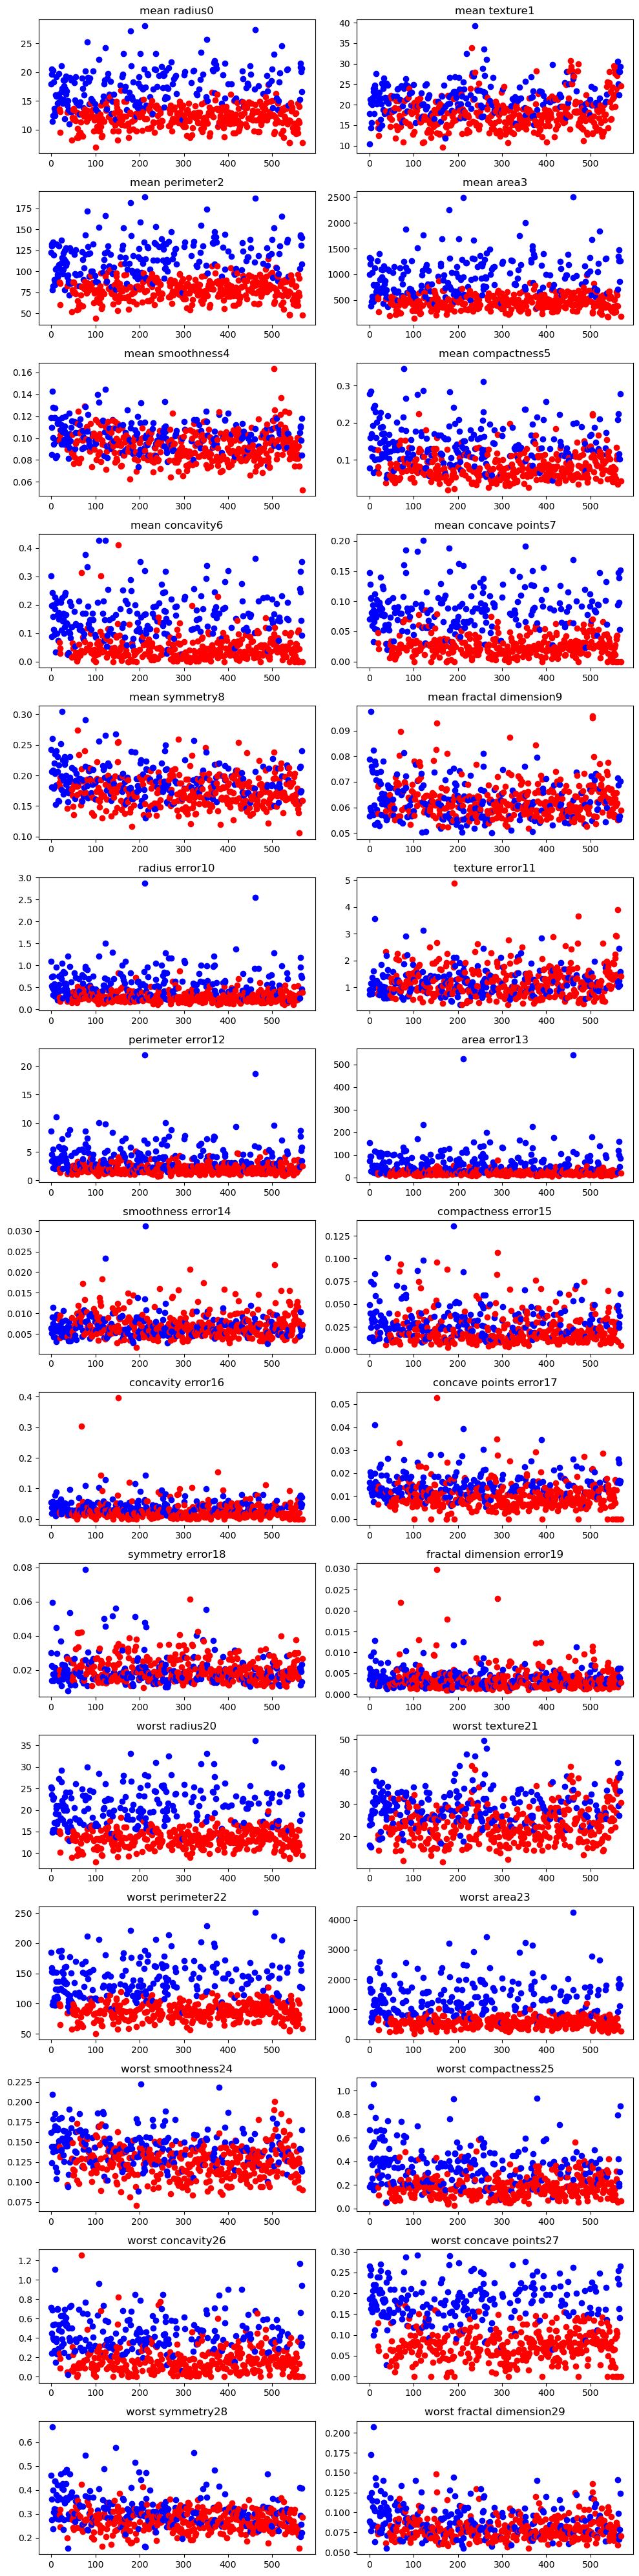

In [38]:
# visulaize the data
fig, ax = plt.subplots(15, 2, figsize=(10, 40))  # Adjust size as needed
ax = ax.ravel()  # Flatten the 2D array of axes to 1D for easier indexing

for j in range(len(df_scaled.columns)):
    for i, d in enumerate(targets_adj):
        if d == 1:
            ax[j].scatter(i, df.values[i, j], color='red')
        else:
            ax[j].scatter(i, df.values[i, j], color='blue')
    ax[j].set_title(f'{df.columns[j]}{j}')  # Add title to each subplot

plt.tight_layout()  # Adjust the spacing between plots
plt.show()

# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iloc.html 

In [39]:
### features with some correlation to diagnosis
feature_idx = np.array([0,2,3,6,7,10,12,13,20,22,23,25,26,27])
num_cols = len(feature_idx)
# select only linearly separable columns
df_selected = df_scaled.iloc[:, feature_idx]
df_selected.T

,0,1,2,3,4,5,6,7,8,9,...,559,560,561,562,563,564,565,566,567,568
mean radius,0.521037,0.643144,0.601496,0.210090,0.629893,0.258839,0.533343,0.318472,0.284869,0.259312,...,0.214350,0.334564,0.199678,0.389938,0.659709,0.690000,0.622320,0.455251,0.644564,0.036869
mean perimeter,0.545989,0.615783,0.595743,0.233501,0.630986,0.267984,0.523875,0.320710,0.302052,0.277659,...,0.212356,0.328865,0.185751,0.411927,0.685578,0.678668,0.604036,0.445788,0.665538,0.028540
mean area,0.363733,0.501591,0.449417,0.102906,0.489290,0.141506,0.380276,0.184263,0.159618,0.140997,...,0.110286,0.193807,0.102863,0.243224,0.510498,0.566490,0.474019,0.303118,0.475716,0.015907
mean concavity,0.703140,0.203608,0.462512,0.565604,0.463918,0.369728,0.264058,0.219447,0.435567,0.532568,...,0.260544,0.104545,0.000000,0.597470,0.743674,0.571462,0.337395,0.216753,0.823336,0.000000
mean concave points,0.731113,0.348757,0.635686,0.522863,0.518390,0.402038,0.367793,0.297465,0.464861,0.424602,...,0.204026,0.213917,0.000000,0.468638,0.732604,0.690358,0.486630,0.263519,0.755467,0.000000
radius error,0.356147,0.156437,0.229622,0.139091,0.233822,0.080753,0.121383,0.170922,0.070541,0.067391,...,0.046098,0.091617,0.073366,0.053848,0.308057,0.385479,0.236828,0.124896,0.222524,0.099294
perimeter error,0.369034,0.124440,0.180370,0.126655,0.220563,0.068793,0.114169,0.146021,0.077699,0.060406,...,0.055553,0.100410,0.060500,0.075626,0.376997,0.325873,0.209490,0.125713,0.236300,0.084390
area error,0.273811,0.125660,0.162922,0.038155,0.163688,0.038080,0.087987,0.082477,0.032720,0.032010,...,0.018991,0.043030,0.029899,0.029600,0.209186,0.283710,0.172279,0.077976,0.148335,0.023063
worst radius,0.620776,0.606901,0.556386,0.248310,0.519744,0.268232,0.531839,0.324795,0.268943,0.254714,...,0.161864,0.262184,0.141942,0.341160,0.581999,0.623266,0.560655,0.393099,0.633582,0.054287
worst perimeter,0.668310,0.539818,0.508442,0.241347,0.506948,0.263908,0.511928,0.299766,0.277852,0.235271,...,0.158723,0.247971,0.123413,0.389910,0.640918,0.576174,0.520892,0.379949,0.668310,0.043578


In [40]:
# run model on selected features
run_model(df_selected.values, targets_adj)

PLA converged after 0 iterations.
PLA converged after 2 iterations.
N: Ein   Eout
10: 0.00%  4.35%
50: 0.00%  1.45%
100: 1.00%  1.45%
200: 2.00%  1.45%
250: 2.80%  1.45%
300: 3.67%  1.45%
350: 3.43%  2.90%
400: 4.00%  1.45%
450: 3.33%  1.45%
500: 3.60%  1.45%


## DT 4: correlated linearly separable features

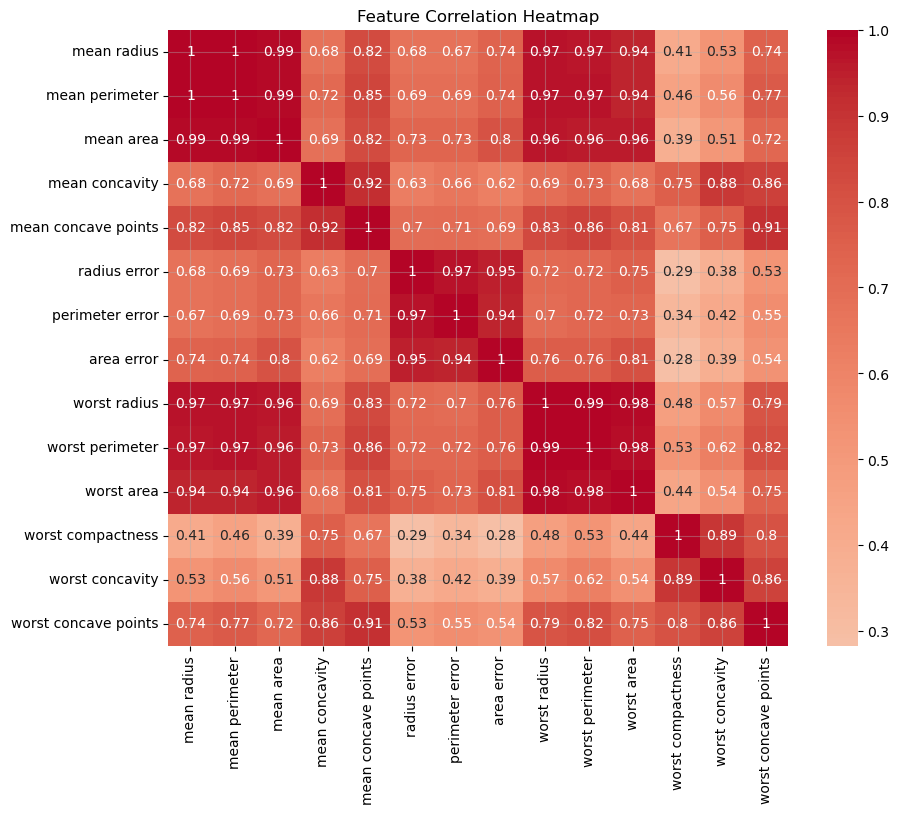

In [42]:
# make a heatmap of the features and look for heavy correlations (positive or negative)
correlation_matrix_selected = df_selected.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_selected, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.grid(alpha=0.4)
plt.show()

In [43]:
features_to_remove = ['mean perimeter', 
                      'mean area', 
                      'worst radius', 
                      'worst perimeter',
                      'worst area']
# Get the indices of these features in the DataFrame
indices = df_selected.columns.get_indexer(features_to_remove)
print("Indices of features to remove:", indices)

# Drop these features from the DataFrame
df_selected_reduced = df_selected.drop(columns=features_to_remove)
df_selected_reduced

Indices of features to remove: [ 1  2  8  9 10]


,mean radius,mean concavity,mean concave points,radius error,perimeter error,area error,worst compactness,worst concavity,worst concave points
0,0.521037,0.703140,0.731113,0.356147,0.369034,0.273811,0.619292,0.568610,0.912027
1,0.643144,0.203608,0.348757,0.156437,0.124440,0.125660,0.154563,0.192971,0.639175
2,0.601496,0.462512,0.635686,0.229622,0.180370,0.162922,0.385375,0.359744,0.835052
3,0.210090,0.565604,0.522863,0.139091,0.126655,0.038155,0.814012,0.548642,0.884880
4,0.629893,0.463918,0.518390,0.233822,0.220563,0.163688,0.172415,0.319489,0.558419
...,...,...,...,...,...,...,...,...,...
564,0.690000,0.571462,0.690358,0.385479,0.325873,0.283710,0.178527,0.328035,0.761512
565,0.622320,0.337395,0.486630,0.236828,0.209490,0.172279,0.159997,0.256789,0.559450
566,0.455251,0.216753,0.263519,0.124896,0.125713,0.077976,0.273705,0.271805,0.487285
567,0.644564,0.823336,0.755467,0.222524,0.236300,0.148335,0.815758,0.749760,0.910653


In [44]:
# run model with correlated features removed
run_model(df_selected_reduced.values, targets_adj)

PLA converged after 0 iterations.
PLA converged after 66 iterations.
N: Ein   Eout
10: 0.00%  5.80%
50: 0.00%  4.35%
100: 2.00%  5.80%
200: 3.50%  4.35%
250: 3.60%  4.35%
300: 4.67%  5.80%
350: 4.86%  5.80%
400: 5.00%  5.80%
450: 4.67%  5.80%
500: 4.80%  4.35%


### Again seem to have lost information by removing highly correlated features. Obviously some important information is contained in the relationships with the other features